In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
#from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output
from typing import NamedTuple
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()


try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        init_budget,
        sampler, 
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.init_budget = init_budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.stocks = self.df.columns.tolist()
        
        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        # if sampler_args:
        #     self.sampler_args = json.loads(str(sampler_args))
        # else:
        #     self.sampler_args = {}

        #self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.sampler = sampler
        self.solution = {}
        self.precision = 2

        self.list_dates = self.df.index.values

    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        print(f'idx: {idx}')
        #print(f'self.df')
        #display(self.df.head())
        #print(f'self.df.index.values: {self.df.index.values}')
        #print(f'self.list_dates: {self.list_dates}')
        self.position = np.where(self.list_dates == idx)[0][0]
        print(f'self.position: {self.position}')
        #self.position2 = np.where(self.list_dates == idx)[0]
        #print(f'self.position 2: {self.position2}')
        self.initial_position = self.list_dates[self.position-5]
        print(f'self.initial_position: {self.initial_position}')
        #print('self.df')
        #display(self.df)
        self.price = self.df.loc[idx, :]
        print(f'sum price: {self.price.sum()}')
        #print('price')
        #print(self.price)
        self.pct_returns = self.df.pct_change()
        self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        print(f'sum daily returns: {self.daily_returns.stack().sum()}')
        #self.avg_daily_returns = self.daily_returns.rolling(window=1).mean().loc[idx,:]
        self.avg_daily_returns = self.preds
        print(f'avg daily returns: {self.avg_daily_returns.sum()}')
        # print('avg daily returns 2')
        # display(self.avg_daily_returns2.head())
        self.covariance_matrix = self.daily_returns.cov()
        self.correlation_matrix = self.daily_returns.corr()
        print('cov matrix')
        display(self.covariance_matrix.head())
        print(f'covariance_matrix sum: {self.covariance_matrix.stack().sum()}')
        print('corr matrix')
        display(self.correlation_matrix.head())
        print(f'correlation_matrix sum: {self.correlation_matrix.stack().sum()}')

        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]       
        #print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]
        #print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'self.init_holdings: {self.init_holdings}')
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')
            print(f'upper bound = budget: {self.budget}')
            print(f'init_budget: {self.init_budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')
            print(f'lhs: {lhs}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            print('cqm debugging')
            print(f'risk: {type(risk)}')
            print(f'returns: {returns}')
            print(f'objective: {self.alpha*risk - returns}')

            cqm.set_objective(self.alpha*risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        sum_solution = 0
        for s1 in solution:
            #print(f's1: {s1}, {solution[s1]}, price: {self.price[s1]}')
            sum_solution += solution[s1]
            #print(f'covariance matrix: {self.covariance_matrix[s1].sum()}')

        print(f'MMM price: {self.price["MMM"]}, solution: {solution["MMM"]}')
        print(f'sum price: {sum(self.price)}')
        print(f'sum solution: {sum_solution}')

        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        self.stocks = sorted(self.stocks)

        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type
        
        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        #print('initial baseline')
        #display(self.baseline)
        #print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        self.init_budget = budget
        #print('final baseline')
        #display(self.baseline)
        #print('initial data')
        #display(self.df.head())

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}

        print('iniital_holdings')
        print(self.init_holdings)
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = sorted(self.stocks)
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}
        # self.sample_set = {}
        # self.sampler_args = sampler_args
        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []
        
        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        #row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            #print('df train')
            #display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            # single_period = SinglePeriod(data=self.df, 
            #                              preds=self.preds.pct_change().iloc[-1,:], 
            #                              budget=self.budget, 
            #                              init_budget = self.init_budget,
            #                              sampler_args=self.sampler_args, 
            #                              dates=self.dates,
            #                              model_type=self.model_type,
            #                              alpha=self.alpha,
            #                              verbose=self.verbose,
            #                              t_cost=self.t_cost,
            #                              label=self.label,
            #                              init_holdings=self.init_holdings)

            if first_purchase:
                print(f'first purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                # single_period = SinglePeriod(data=self.df, 
                #                          preds=self.preds.pct_change().iloc[-1,:], 
                #                          budget=self.budget, 
                #                          init_budget = self.init_budget,
                #                          sampler_args=self.sampler_args, 
                #                          dates=self.dates,
                #                          model_type=self.model_type,
                #                          alpha=self.alpha,
                #                          verbose=self.verbose,
                #                          t_cost=self.t_cost,
                #                          label=self.label,
                #                          init_holdings=self.init_holdings)
                initial_budget = self.budget
                
                baseline_shares = (self.budget / baseline_current)
                #display(self.baseline)
                #self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #self.init_holdings = self.solution['stocks']
                #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            else:
                #self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                self.budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    self.budget = 0
                print(f'new purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                
                
                # if self.t_cost and not first_purchase:
                #     self.budget = 0
            
            single_period = SinglePeriod(data=self.df, 
                                            preds=self.preds.pct_change().iloc[-1,:], 
                                            budget=self.budget, 
                                            init_budget = self.init_budget,
                                            sampler=self.sampler, 
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            
            
            #print(f'budget before calculation: {self.budget}, initial_budget: {initial_budget}')
            print(f'init_holdings before calculation: {self.init_holdings}')
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'final budget: {sum([self.price[s]*self.solution["stocks"][s] for s in self.stocks])}')
            print(f'init_holdings after calculation: {self.init_holdings}')

            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            print(f'sum shares: {sum([self.solution["stocks"][s] for s in self.stocks])}')
            returns = self.solution['return']
            variance = self.solution['risk']

            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            first_purchase = False

            #clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

        return None

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    print(f'stocks: {stocks}')
    #panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    panel_data = pdr.get_data_yahoo(stocks, start=initial_date, end=dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    #index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    index_df = pdr.get_data_yahoo(baseline, start=dates[0], end=dates[1])
    df_baseline = index_df['Adj Close'].to_frame().rename(columns={'Adj Close': '^GSPC'})
    #df_baseline = pd.DataFrame(index=index_df.index, columns=['Adj Close'])
    #for i in baseline:
    #    df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:  
                if b == '0':
                    inverse_s += '1'       
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)
            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            if total <= budget and total > 0.9 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.hist(score_report) 
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0   
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]
    
        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8)) 
            ax[0].hist(scores) 
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.005,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'n_iter': 10000,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'RunTest',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()
#stocks = ['MMM', 'GOOG', 'AAP']
#print(f'stocks: {stocks}')
stocks = sorted(stocks)
print(f'stocks: {stocks}')

df, df_baseline = load_data(initial_date, dates, stocks, baseline)



stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISH

init holdings df


,a,b
0,MMM,1
1,AOS,1
2,ABT,25
3,ABBV,69
4,ABMD,1


prices: [135.9786376953125, 24.670000076293945, 185.24697875976562, 123.1982192993164, 105.53199005126953, 112.07742309570312, 279.70001220703125, 103.25084686279297, 39.86000061035156, 275.5017395019531, 495.9100036621094, 159.36207580566406, 65.89518737792969, 190.40975952148438, 281.29998779296875, 80.45933532714844, 80.83892059326172, 24.623825073242188, 55.12178039550781, 51.42155838012695, 157.54055786132812, 143.43539428710938, 113.8499984741211, 169.3777618408203, 593.47998046875, 69.54000091552734, 131.875732421875, 136.60427856445312, 136.46994018554688, 11.205267906188965, 80.80999755859375, 134.2530975341797, 222.8223114013672, 255.83148193359375, 250.196044921875, 160.9324951171875, 83.71749877929688, 335.989990234375, 250.4621124267578, 69.65415954589844, 22.60394859313965, 291.82318115234375, 66.3968505859375, 154.91000366210938, 173.73887634277344, 95.71971130371094, 95.88007354736328, 201.63662719726562, 444.07769775390625, 217.6431427001953, 150.5704803466797, 160.842

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000183,3.037185e-05,-7.330306e-05,-0.000048,-0.000073,0.000065,0.000096,0.000193,0.000123,-0.000057,-0.000067,0.000007,-0.000044,0.000090,-0.000075,-0.000008,2.540396e-05,-0.000029,3.636189e-05,0.000119,0.000124,0.000044,0.000014,0.000122,0.000044,0.000055,0.000017,0.000060,0.000021,0.000032,-0.000040,2.446773e-05,0.000017,0.000066,-0.000045,-0.000055,0.000008,0.000006,0.000070,0.000054,-0.000160,-0.000003,-0.000003,0.000180,-0.000067,0.000020,0.000013,-0.000076,1.011693e-04,2.738863e-05,-0.000044,-0.000016,0.000030,0.000105,0.000053,0.000095,-0.000035,2.457537e-05,0.000065,2.020365e-05,0.000124,0.000039,0.000150,0.000051,0.000015,-3.122000e-05,-0.000003,0.000015,0.000056,0.000086,0.000018,-0.000002,-0.000031,0.000060,0.000005,0.000034,0.000004,0.000071,0.000080,-0.000007,-0.000078,-0.000018,0.000008,0.000028,0.000039,0.000084,0.000019,0.000016,0.000092,-0.000048,0.000018,0.000036,2.506676e-05,1.015809e-04,-0.000006,-0.000023,0.000095,0.000041,0.000120,0.000094,0.000042,-2.333296e-05,0.000035,0.000012,-0.000009,0.000073,-0.000086,0.000029,-0.000069,0.000092,-0.000106,0.000183,-0.000093,0.000032,-0.000047,-0.000029,0.000010,0.000091,-0.000136,0.000021,0.000033,-0.000003,-1.037388e-04,0.000011,0.000001,0.000035,0.000099,0.000044,0.000034,0.000104,0.000063,0.000035,0.000189,0.000060,0.000072,-0.000057,-0.000441,0.000061,-0.000084,0.000056,0.000113,0.000047,-0.000039,0.000021,-0.000316,0.000212,0.000140,-0.000066,-0.000203,0.000033,-0.000044,0.000097,5.768764e-07,-0.000021,0.000060,-0.000003,0.000091,0.000020,-0.000077,-0.000051,-0.000037,-0.000040,-0.000224,0.000043,-0.000088,0.000045,0.000006,-0.000050,3.983691e-05,-0.000079,-0.000042,0.000096,-0.000054,-0.000046,0.000245,-0.000150,0.000009,0.000085,9.240064e-05,0.000123,0.000043,0.000156,0.000059,0.000042,0.000063,0.000044,0.000016,0.000125,0.000067,0.000100,-0.000102,-0.000095,0.000041,0.000042,5.534259e-05,0.000337,-0.000011,0.000011,-0

covariance_matrix sum: 3.9031552462711923
corr matrix


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.173425,-0.321862,-0.418063,-0.529638,0.409423,0.578564,0.367889,0.753910,-0.509623,-0.301472,0.058293,-0.350740,0.704733,-0.352345,-0.091429,0.344049,-0.216942,0.317713,0.558375,0.828772,0.727050,0.189281,0.428356,0.226158,0.252282,0.148152,0.710715,0.082364,0.308578,-0.410644,0.440408,0.107788,0.578868,-0.631526,-0.511553,0.061306,0.035916,0.899861,0.540923,-0.231628,-0.027238,-0.043004,0.640216,-0.456172,0.608124,0.137041,-0.656512,0.750506,0.250428,-0.482446,-0.132951,0.282471,0.403219,0.378836,0.389846,-0.622270,0.223219,0.340437,0.254420,0.702022,0.296324,0.682240,0.471272,0.082571,-0.083304,-0.046812,0.196715,0.910885,0.883195,0.080941,-0.008074,-0.203782,0.471466,0.102637,0.260058,0.047879,0.662321,0.684634,-0.063254,-0.466065,-0.296379,0.036836,0.177127,0.242984,0.774735,0.133654,0.057821,0.476509,-0.486814,0.118799,0.283064,0.669169,0.737239,-0.059589,-0.463692,0.477403,0.312275,0.683622,0.888951,0.281619,-0.281173,0.684858,0.107479,-0.037736,0.592777,-0.294742,0.185965,-0.504676,0.562000,-0.809233,0.795485,-0.275262,0.255349,-0.554435,-0.300695,0.098160,0.481314,-0.341850,0.404545,0.279660,-0.036652,-0.474501,0.040225,0.009119,0.235700,0.513604,0.413971,0.170298,0.371847,0.295617,0.254160,0.680971,0.652464,0.298241,-0.502745,-0.953293,0.773226,-0.463217,0.451469,0.436939,0.299926,-0.569219,0.501764,-0.435635,0.830139,0.554738,-0.674307,-0.799263,0.599133,-0.437771,0.911070,0.002134,-0.152307,0.747495,-0.012925,0.619527,0.070965,-0.239035,-0.329539,-0.393767,-0.337622,-0.463495,0.552654,-0.619674,0.570036,0.093786,-0.345461,0.289222,-0.411858,-0.229275,0.520380,-0.467576,-0.426732,0.371750,-0.315346,0.099560,0.306156,0.476084,0.817170,0.607962,0.705951,0.663561,0.415320,0.470794,0.568326,0.138706,0.751092,0.471356,0.813491,-0.724226,-0.382977,0.301495,0.633673,0.867359,0.775165,-0.059583,0.084362,-0.447665,0.509795,0.095563,0.541955,0.541904,-0.525061,-0.362137,-0.30438

correlation_matrix sum: 27481.196325402092
t_cost False
cqm debugging
risk: <class 'dimod.quadratic.quadratic_model.QuadraticModel'>
returns: QuadraticModel({'A': -0.23333672017124862, 'AAL': 0.00034611578470192163, 'AAP': -0.07703134933486808, 'AAPL': 0.15444962857623268, 'ABBV': 0.25339285191544614, 'ABC': 0.4305213195171633, 'ABMD': 1.2246950414231557, 'ABT': 0.4879736955341743, 'ACGL': 0.06096950482281189, 'ACN': 0.27462066210673686, 'ADBE': -0.6313039395862876, 'ADI': 0.3000717445120218, 'ADM': -0.05354462712455453, 'ADP': -0.8321626538461762, 'ADSK': -0.7207269167330483, 'AEE': -0.027300587780051278, 'AEP': -0.12259676891456098, 'AES': 0.010025941674759264, 'AFL': -0.14659014750891797, 'AIG': -0.3263967198112646, 'AIZ': -0.48171358373025014, 'AJG': -0.09922404365497814, 'AKAM': 0.16659628407623775, 'ALB': -1.7499188586340406, 'ALGN': -0.4551302242756562, 'ALK': -0.4469250232374851, 'ALL': -0.7054718479945492, 'ALLE': -0.23159354355032913, 'AMAT': 0.3270081701411382, 'AMCR': -0.00

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_samples: 72
solution_stocks: {'A': 7, 'AAL': 207, 'AAP': 11, 'AAPL': 33, 'ABBV': 27, 'ABC': 5, 'ABMD': 9, 'ABT': 6, 'ACGL': 51, 'ACN': 13, 'ADBE': 45, 'ADI': 15, 'ADM': 3, 'ADP': 0, 'ADSK': 5, 'AEE': 8, 'AEP': 30, 'AES': 0, 'AFL': 126, 'AIG': 38, 'AIZ': 0, 'AJG': 22, 'AKAM': 4, 'ALB': 0, 'ALGN': 0, 'ALK': 13, 'ALL': 74, 'ALLE': 7, 'AMAT': 25, 'AMCR': 189, 'AMD': 12, 'AME': 53, 'AMGN': 8, 'AMP': 0, 'AMT': 4, 'AMZN': 16, 'ANET': 7, 'ANSS': 0, 'AON': 0, 'AOS': 32, 'APA': 26, 'APD': 6, 'APH': 5, 'APTV': 4, 'ARE': 16, 'ATO': 8, 'ATVI': 32, 'AVB': 5, 'AVGO': 0, 'AVY': 0, 'AWK': 36, 'AXP': 0, 'AZO': 0, 'BA': 7, 'BAC': 19, 'BALL': 41, 'BAX': 0, 'BBWI': 48, 'BBY': 40, 'BDX': 31, 'BEN': 39, 'BIIB': 9, 'BIO': 0, 'BK': 89, 'BKNG': 0, 'BKR': 97, 'BLK': 0, 'BMY': 290, 'BR': 35, 'BRO': 56, 'BSX': 14, 'BWA': 64, 'BXP': 15, 'C': 38, 'CAG': 40, 'CAH': 12, 'CARR': 1, 'CAT': 0, 'CB': 2, 'CBOE': 14, 'CBRE': 37, 'CCI': 16, 'CCL': 142, 'CDAY': 0, 'CDNS': 53, 'CDW': 23, 'CE': 5, 'CF': 2, 'CFG': 29, 'CHD': 7

,idx,variance,returns,value,value_norm
0,2021-06-01,84941.96,-918.79,1.310273e+06,0.0


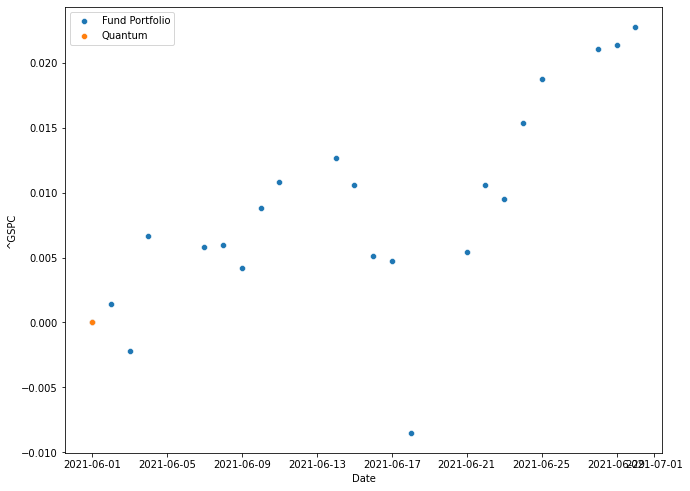


Run completed.

idx: 2021-06-02 00:00:00
new purchase budget: 1314370.6147556305, initial_budget: 1310332.3100309372
init_holdings before calculation: {'A': 7, 'AAL': 207, 'AAP': 11, 'AAPL': 33, 'ABBV': 27, 'ABC': 5, 'ABMD': 9, 'ABT': 6, 'ACGL': 51, 'ACN': 13, 'ADBE': 45, 'ADI': 15, 'ADM': 3, 'ADP': 0, 'ADSK': 5, 'AEE': 8, 'AEP': 30, 'AES': 0, 'AFL': 126, 'AIG': 38, 'AIZ': 0, 'AJG': 22, 'AKAM': 4, 'ALB': 0, 'ALGN': 0, 'ALK': 13, 'ALL': 74, 'ALLE': 7, 'AMAT': 25, 'AMCR': 189, 'AMD': 12, 'AME': 53, 'AMGN': 8, 'AMP': 0, 'AMT': 4, 'AMZN': 16, 'ANET': 7, 'ANSS': 0, 'AON': 0, 'AOS': 32, 'APA': 26, 'APD': 6, 'APH': 5, 'APTV': 4, 'ARE': 16, 'ATO': 8, 'ATVI': 32, 'AVB': 5, 'AVGO': 0, 'AVY': 0, 'AWK': 36, 'AXP': 0, 'AZO': 0, 'BA': 7, 'BAC': 19, 'BALL': 41, 'BAX': 0, 'BBWI': 48, 'BBY': 40, 'BDX': 31, 'BEN': 39, 'BIIB': 9, 'BIO': 0, 'BK': 89, 'BKNG': 0, 'BKR': 97, 'BLK': 0, 'BMY': 290, 'BR': 35, 'BRO': 56, 'BSX': 14, 'BWA': 64, 'BXP': 15, 'C': 38, 'CAG': 40, 'CAH': 12, 'CARR': 1, 'CAT': 0, 'CB': 

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000201,-0.000027,-0.000027,-0.000072,-0.000073,4.285464e-05,0.000093,0.000134,0.000140,-0.000071,-0.000074,-0.000004,-0.000034,0.000071,-0.000081,-0.000030,0.000007,-0.000005,0.000042,0.000145,0.000150,0.000047,-0.000006,0.000163,0.000082,0.000094,0.000019,0.000072,6.798050e-06,0.000040,-0.000048,0.000027,-0.000014,0.000075,-0.000068,-0.000071,0.000005,-0.000009,7.168526e-05,0.000075,-0.000150,-0.000018,-0.000007,0.000215,-0.000080,0.000006,0.000028,-0.000084,0.000083,0.000057,-0.000058,-0.000011,0.000030,0.000125,0.000053,0.000079,-2.576534e-05,0.000109,0.000015,0.000011,0.000113,0.000013,0.000143,0.000061,0.000011,-0.000073,-0.000027,0.000011,0.000048,0.000094,0.000067,0.000010,-0.000042,0.000065,-0.000027,0.000011,0.000053,0.000069,9.292223e-05,-0.000036,-0.000086,-0.000041,-0.000035,0.000049,0.000046,5.859675e-05,0.000049,0.000049,0.000116,-0.000064,0.000023,0.000038,0.000035,0.000098,-0.000024,-0.000041,0.000118,0.000055,0.000087,0.000095,0.000066,-0.000034,4.667570e-05,0.000010,0.000005,0.000088,-0.000094,0.000010,-9.288249e-05,0.000100,-0.000130,0.000199,-0.000071,0.000008,-0.000027,-0.000015,0.000006,0.000109,-0.000178,0.000020,0.000048,-0.000023,-0.000127,0.000009,-0.000022,0.000038,0.000113,0.000088,0.000051,0.000119,0.000052,0.000088,0.000196,0.000085,5.314884e-07,-0.000070,-0.000453,0.000063,-0.000042,0.000050,0.000110,0.000039,-0.000057,0.000020,-0.000292,0.000146,1.135684e-04,-0.000039,-0.000256,3.218559e-05,-0.000060,9.979886e-05,-0.000035,-0.000022,0.000065,0.000035,0.000096,0.000022,-0.000068,-0.000071,-0.000070,-0.000046,-0.000198,0.000011,-0.000115,0.000056,-0.000004,-0.000173,0.000022,-0.000053,-0.000053,0.000095,-0.000024,-0.000057,0.000295,-0.000102,7.369134e-06,0.000139,0.000069,0.000143,0.000040,0.000115,0.000042,0.000025,0.000076,0.000037,0.000031,0.000142,0.000092,0.000089,-0.000126,-0.000086,0.000030,0.000011,0.000037,0.000376,-0.000052,-0.000014,-0.000061,0.00

covariance_matrix sum: 3.0698446008378553
corr matrix


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,-0.104274,-0.123910,-0.834068,-0.516111,0.234323,0.536786,0.237355,0.778249,-0.619237,-0.375859,-0.048256,-0.279736,0.533554,-0.473414,-0.258547,0.078395,-0.031844,0.350636,0.605140,0.849580,0.727481,-0.071580,0.526171,0.388827,0.367549,0.153985,0.802128,0.056240,0.372805,-0.468890,0.484152,-0.070474,0.627764,-0.719944,-0.869049,0.047788,-0.169826,0.883536,0.671784,-0.211131,-0.156690,-0.243910,0.705269,-0.644156,0.094007,0.292878,-0.734547,0.667191,0.375802,-0.544014,-0.083879,0.268829,0.447526,0.368301,0.327708,-0.396240,0.352467,0.055474,0.122068,0.614574,0.076410,0.621391,0.512834,0.090962,-0.174843,-0.403642,0.209852,0.732153,0.894459,0.241173,0.052635,-0.341965,0.486546,-0.232672,0.068380,0.280935,0.640529,0.758528,-0.256357,-0.582708,-0.406093,-0.137960,0.312035,0.437074,0.499167,0.271829,0.162126,0.545252,-0.587401,0.172664,0.503878,0.678798,0.688192,-0.223499,-0.593643,0.559332,0.383521,0.409808,0.908411,0.411363,-0.360925,0.726975,0.112605,0.021853,0.834077,-0.306377,0.062867,-0.567538,0.623378,-0.899037,0.824182,-0.198713,0.119187,-0.241861,-0.141782,0.196241,0.532572,-0.658887,0.371825,0.370390,-0.243434,-0.560723,0.058434,-0.155472,0.292737,0.570626,0.491960,0.239388,0.764847,0.228500,0.390091,0.688749,0.668759,0.001586,-0.555347,-0.934354,0.811096,-0.178428,0.535260,0.414102,0.293109,-0.607445,0.471009,-0.383687,0.416929,0.600713,-0.299590,-0.798510,0.649109,-0.506653,0.946657,-0.119239,-0.213820,0.799596,0.119947,0.628175,0.079036,-0.205004,-0.522491,-0.470853,-0.397140,-0.465318,0.081278,-0.708244,0.632949,-0.052836,-0.388370,0.148681,-0.252239,-0.285227,0.562964,-0.160468,-0.481533,0.457939,-0.198055,0.095391,0.405059,0.320059,0.847207,0.536087,0.474010,0.436579,0.440180,0.527828,0.435264,0.246731,0.775088,0.548516,0.678181,-0.750943,-0.340941,0.221596,0.099644,0.414775,0.826241,-0.328556,-0.095922,-0.514764,0.499769,0.119409,0.641436,0.580377,-0.760894,-0.632876,

correlation_matrix sum: 16834.357410991543
t_cost False
cqm debugging
risk: <class 'dimod.quadratic.quadratic_model.QuadraticModel'>
returns: QuadraticModel({'A': -0.1733120097879902, 'AAL': 0.1861175537335069, 'AAP': 0.27182649152521193, 'AAPL': -0.16606841293685, 'ABBV': -0.08510074935941425, 'ABC': 0.1541011310396849, 'ABMD': -1.3110201674708815, 'ABT': 0.45617652569506517, 'ACGL': -0.024818393574884214, 'ACN': -0.7063279774080944, 'ADBE': -0.9669714905761803, 'ADI': -0.09455334849152137, 'ADM': 0.14809018889971767, 'ADP': -0.11709758204115982, 'ADSK': -0.979997586130037, 'AEE': 0.004694208512703802, 'AEP': 0.15435164675789248, 'AES': -0.00587131700465444, 'AFL': 0.07918524984585346, 'AIG': 0.015883385716207805, 'AIZ': -0.16916651917557704, 'AJG': -0.04888854480518566, 'AKAM': 0.18558451305857032, 'ALB': 0.8452286903554321, 'ALGN': 3.1019991294862646, 'ALK': 0.25246399929048874, 'ALL': 0.07373172689919487, 'ALLE': 0.03334613405130218, 'AMAT': -0.1258763532613629, 'AMCR': -0.00210452

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_samples: 82
solution_stocks: {'A': 0, 'AAL': 194, 'AAP': 0, 'AAPL': 28, 'ABBV': 22, 'ABC': 36, 'ABMD': 0, 'ABT': 0, 'ACGL': 54, 'ACN': 31, 'ADBE': 53, 'ADI': 78, 'ADM': 16, 'ADP': 0, 'ADSK': 0, 'AEE': 4, 'AEP': 32, 'AES': 14, 'AFL': 33, 'AIG': 0, 'AIZ': 0, 'AJG': 8, 'AKAM': 22, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 20, 'ALLE': 20, 'AMAT': 32, 'AMCR': 233, 'AMD': 0, 'AME': 5, 'AMGN': 0, 'AMP': 0, 'AMT': 11, 'AMZN': 29, 'ANET': 22, 'ANSS': 12, 'AON': 4, 'AOS': 29, 'APA': 244, 'APD': 18, 'APH': 1, 'APTV': 0, 'ARE': 20, 'ATO': 2, 'ATVI': 0, 'AVB': 10, 'AVGO': 0, 'AVY': 0, 'AWK': 7, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 55, 'BAX': 15, 'BBWI': 21, 'BBY': 55, 'BDX': 9, 'BEN': 21, 'BIIB': 0, 'BIO': 0, 'BK': 141, 'BKNG': 0, 'BKR': 75, 'BLK': 3, 'BMY': 8, 'BR': 0, 'BRO': 36, 'BSX': 80, 'BWA': 73, 'BXP': 30, 'C': 14, 'CAG': 4, 'CAH': 24, 'CARR': 0, 'CAT': 0, 'CB': 0, 'CBOE': 0, 'CBRE': 25, 'CCI': 39, 'CCL': 78, 'CDAY': 0, 'CDNS': 42, 'CDW': 0, 'CE': 0, 'CF': 0, 'CFG': 18, 'CHD': 29, 'C

,idx,variance,returns,value,value_norm
0,2021-06-01,84941.96,-918.79,1.310273e+06,0.000000
0,2021-06-02,1788.74,530.02,1.314365e+06,0.003123


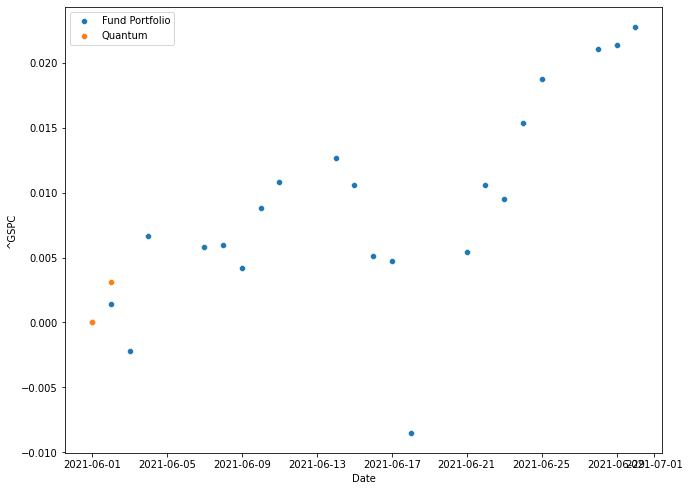


Run completed.

idx: 2021-06-03 00:00:00
new purchase budget: 1312883.9533977509, initial_budget: 1310332.3100309372
init_holdings before calculation: {'A': 0, 'AAL': 194, 'AAP': 0, 'AAPL': 28, 'ABBV': 22, 'ABC': 36, 'ABMD': 0, 'ABT': 0, 'ACGL': 54, 'ACN': 31, 'ADBE': 53, 'ADI': 78, 'ADM': 16, 'ADP': 0, 'ADSK': 0, 'AEE': 4, 'AEP': 32, 'AES': 14, 'AFL': 33, 'AIG': 0, 'AIZ': 0, 'AJG': 8, 'AKAM': 22, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 20, 'ALLE': 20, 'AMAT': 32, 'AMCR': 233, 'AMD': 0, 'AME': 5, 'AMGN': 0, 'AMP': 0, 'AMT': 11, 'AMZN': 29, 'ANET': 22, 'ANSS': 12, 'AON': 4, 'AOS': 29, 'APA': 244, 'APD': 18, 'APH': 1, 'APTV': 0, 'ARE': 20, 'ATO': 2, 'ATVI': 0, 'AVB': 10, 'AVGO': 0, 'AVY': 0, 'AWK': 7, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 55, 'BAX': 15, 'BBWI': 21, 'BBY': 55, 'BDX': 9, 'BEN': 21, 'BIIB': 0, 'BIO': 0, 'BK': 141, 'BKNG': 0, 'BKR': 75, 'BLK': 3, 'BMY': 8, 'BR': 0, 'BRO': 36, 'BSX': 80, 'BWA': 73, 'BXP': 30, 'C': 14, 'CAG': 4, 'CAH': 24, 'CARR': 0, 'CAT': 0, 'CB': 0,

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000202,0.000022,-0.000040,-0.000061,-0.000093,-0.000002,0.000094,0.000118,0.000121,-0.000059,-0.000055,0.000020,-0.000040,0.000070,-0.000055,-0.000044,-0.000004,-0.000013,0.000030,0.000115,0.000124,0.000054,0.000004,0.000169,0.000082,0.000117,0.000013,0.000078,0.000049,0.000024,-0.000019,1.603831e-05,-0.000040,0.000066,-0.000067,-5.081481e-05,-0.000022,0.000015,0.000075,0.000113,-0.000179,-7.375939e-06,-1.322612e-05,0.000213,-0.000086,-0.000003,0.000033,-0.000080,0.000105,0.000050,-0.000062,-1.650399e-05,0.000021,0.000163,0.000027,0.000044,-0.000036,0.000146,0.000039,-0.000004,0.000085,-0.000020,0.000142,0.000048,1.741397e-05,-0.000093,-0.000021,3.407706e-07,0.000046,0.000090,0.000078,-0.000013,-0.000034,0.000059,-0.000028,-0.000010,0.000068,0.000061,0.000075,-0.000031,-0.000078,-0.000028,0.000013,0.000067,0.000059,0.000046,0.000028,0.000017,0.000090,-0.000082,-0.000005,0.000038,0.000021,0.000075,-0.000037,-0.000047,0.000101,0.000062,6.799319e-05,0.000121,5.770445e-05,-0.000047,0.000050,-0.000006,-0.000011,0.000089,-0.000123,0.000005,-0.000092,0.000104,-0.000118,0.000187,-0.000050,-0.000001,-0.000008,-0.000019,1.278842e-05,0.000118,-0.000170,0.000026,0.000029,-0.000048,-0.000138,0.000029,-0.000049,0.000087,0.000082,0.000085,0.000034,0.000108,0.000049,0.000130,0.000204,0.000100,-0.000008,-0.000067,-0.000485,5.444790e-05,-0.000076,0.000054,1.195526e-04,0.000014,-0.000077,-0.000002,-0.000307,0.000121,0.000092,-0.000036,-0.000261,3.611860e-05,-0.000075,0.000101,-0.000081,-0.000011,6.099670e-05,0.000007,0.000090,0.000046,-0.000104,-0.000067,-0.000081,-0.000039,-0.000216,-0.000021,-0.000111,0.000047,-0.000024,-0.000102,-0.000009,-0.000052,-0.000091,0.000076,0.000015,-0.000049,0.000201,-0.000123,7.697976e-07,0.000157,0.000079,0.000133,0.000023,0.000098,0.000059,0.000041,0.000061,0.000039,0.000020,0.000144,0.000089,0.000071,-0.000123,-0.000071,0.000042,0.000006,0.000038,0.000373,-0.000045,-0.000

covariance_matrix sum: 1.5877862660060726
corr matrix


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.053476,-0.198782,-0.598227,-0.594914,-0.021731,0.569135,0.199316,0.887939,-0.529816,-0.324907,0.170060,-0.328606,0.550592,-0.328196,-0.577559,-0.042216,-0.102338,0.373955,0.683956,0.764528,0.582899,0.049953,0.528985,0.389899,0.374826,0.152008,0.916331,0.366087,0.270494,-0.092705,0.466389,-0.224625,0.670121,-0.693156,-0.480387,-0.105288,0.124718,0.866847,0.441247,-0.295066,-0.059254,-0.603081,0.707927,-0.685458,-0.061429,0.350011,-0.671555,0.556693,0.357939,-0.567899,-0.144878,0.313134,0.479111,0.261839,0.149725,-0.494600,0.398393,0.123273,-0.034520,0.665184,-0.123233,0.613453,0.627384,0.133255,-0.296377,-0.289926,0.005017,0.690425,0.939737,0.290321,-0.086682,-0.224721,0.538876,-0.246286,-0.096512,0.338084,0.751594,0.735398,-0.211985,-0.466433,-0.244361,0.038059,0.329816,0.877416,0.419122,0.173828,0.074284,0.582302,-0.553619,-0.040234,0.517265,0.293786,0.772904,-0.257075,-0.616974,0.638715,0.407124,0.334380,0.696872,0.375865,-0.481783,0.832326,-0.061945,-0.055656,0.858699,-0.538722,0.032265,-0.557838,0.650447,-0.720357,0.768120,-0.130932,-0.012082,-0.065884,-0.185856,0.631491,0.621029,-0.604245,0.379780,0.333507,-0.343138,-0.713565,0.210257,-0.383898,0.334775,0.607562,0.463647,0.176848,0.609542,0.212828,0.627094,0.744948,0.847073,-0.026211,-0.539056,-0.899424,0.807800,-0.284542,0.548198,0.439332,0.286860,-0.754849,-0.022400,-0.416646,0.379577,0.544324,-0.294329,-0.811726,0.630640,-0.586246,0.948030,-0.684395,-0.120894,0.693248,0.026064,0.667966,0.133212,-0.390892,-0.471076,-0.459967,-0.282529,-0.603486,-0.114052,-0.658523,0.711483,-0.246287,-0.176637,-0.079538,-0.257442,-0.690102,0.449596,0.067841,-0.372747,0.322674,-0.273440,0.009575,0.399988,0.363382,0.830759,0.426362,0.372139,0.442863,0.403819,0.635139,0.439153,0.204819,0.776696,0.537451,0.777807,-0.723484,-0.246911,0.306824,0.057104,0.421110,0.827688,-0.244575,-0.324769,-0.595931,0.854429,-0.016407,0.172738,0.612821,-0.638658

correlation_matrix sum: 7542.373903576488
t_cost False
cqm debugging
risk: <class 'dimod.quadratic.quadratic_model.QuadraticModel'>
returns: QuadraticModel({'A': 0.018942217123881847, 'AAL': -0.0739356082720869, 'AAP': -0.45242324786548255, 'AAPL': 0.3021790624097641, 'ABBV': 0.2905959038500552, 'ABC': -0.05352376666762307, 'ABMD': -0.9384567685851167, 'ABT': 0.31685322648107983, 'ACGL': -0.04185822662276625, 'ACN': 0.5098546800922502, 'ADBE': 1.602379241843897, 'ADI': 0.5868263702712517, 'ADM': 0.06733442885902717, 'ADP': 0.32401466546597496, 'ADSK': 0.37398738275218774, 'AEE': -0.03199989970229506, 'AEP': -0.08807810692482916, 'AES': 0.0040236581184314975, 'AFL': 0.05592741804129205, 'AIG': 0.2804053020013987, 'AIZ': 0.46516975185378967, 'AJG': -0.024311072696654126, 'AKAM': -0.24770244334057756, 'ALB': 0.6462262210060878, 'ALGN': 0.9023379016648087, 'ALK': 0.009178225877505778, 'ALL': 0.2915884588570192, 'ALLE': 0.14835069475396348, 'AMAT': 0.8522500721895281, 'AMCR': -0.00755096559

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_samples: 71
solution_stocks: {'A': 29, 'AAL': 77, 'AAP': 0, 'AAPL': 19, 'ABBV': 61, 'ABC': 0, 'ABMD': 19, 'ABT': 81, 'ACGL': 125, 'ACN': 20, 'ADBE': 0, 'ADI': 25, 'ADM': 26, 'ADP': 5, 'ADSK': 0, 'AEE': 34, 'AEP': 22, 'AES': 127, 'AFL': 59, 'AIG': 8, 'AIZ': 3, 'AJG': 36, 'AKAM': 20, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 28, 'ALLE': 56, 'AMAT': 2, 'AMCR': 189, 'AMD': 38, 'AME': 43, 'AMGN': 15, 'AMP': 4, 'AMT': 2, 'AMZN': 29, 'ANET': 5, 'ANSS': 0, 'AON': 1, 'AOS': 0, 'APA': 21, 'APD': 18, 'APH': 11, 'APTV': 0, 'ARE': 4, 'ATO': 9, 'ATVI': 19, 'AVB': 31, 'AVGO': 0, 'AVY': 9, 'AWK': 39, 'AXP': 0, 'AZO': 0, 'BA': 11, 'BAC': 110, 'BALL': 205, 'BAX': 82, 'BBWI': 1, 'BBY': 0, 'BDX': 19, 'BEN': 7, 'BIIB': 72, 'BIO': 6, 'BK': 86, 'BKNG': 0, 'BKR': 127, 'BLK': 0, 'BMY': 30, 'BR': 4, 'BRO': 1, 'BSX': 14, 'BWA': 1, 'BXP': 4, 'C': 32, 'CAG': 13, 'CAH': 62, 'CARR': 2, 'CAT': 6, 'CB': 4, 'CBOE': 0, 'CBRE': 18, 'CCI': 27, 'CCL': 100, 'CDAY': 0, 'CDNS': 18, 'CDW': 33, 'CE': 28, 'CF': 107, 'CFG': 17, 'CH

,idx,variance,returns,value,value_norm
0,2021-06-01,84941.96,-918.79,1.310273e+06,0.000000
0,2021-06-02,1788.74,530.02,1.314365e+06,0.003123
0,2021-06-03,5467.98,1114.49,1.312768e+06,0.001905


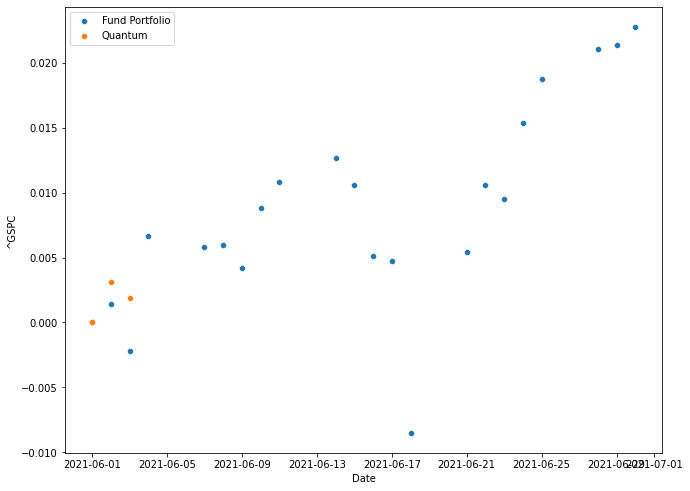


Run completed.

idx: 2021-06-04 00:00:00
new purchase budget: 1319886.4577541351, initial_budget: 1310332.3100309372
init_holdings before calculation: {'A': 29, 'AAL': 77, 'AAP': 0, 'AAPL': 19, 'ABBV': 61, 'ABC': 0, 'ABMD': 19, 'ABT': 81, 'ACGL': 125, 'ACN': 20, 'ADBE': 0, 'ADI': 25, 'ADM': 26, 'ADP': 5, 'ADSK': 0, 'AEE': 34, 'AEP': 22, 'AES': 127, 'AFL': 59, 'AIG': 8, 'AIZ': 3, 'AJG': 36, 'AKAM': 20, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 28, 'ALLE': 56, 'AMAT': 2, 'AMCR': 189, 'AMD': 38, 'AME': 43, 'AMGN': 15, 'AMP': 4, 'AMT': 2, 'AMZN': 29, 'ANET': 5, 'ANSS': 0, 'AON': 1, 'AOS': 0, 'APA': 21, 'APD': 18, 'APH': 11, 'APTV': 0, 'ARE': 4, 'ATO': 9, 'ATVI': 19, 'AVB': 31, 'AVGO': 0, 'AVY': 9, 'AWK': 39, 'AXP': 0, 'AZO': 0, 'BA': 11, 'BAC': 110, 'BALL': 205, 'BAX': 82, 'BBWI': 1, 'BBY': 0, 'BDX': 19, 'BEN': 7, 'BIIB': 72, 'BIO': 6, 'BK': 86, 'BKNG': 0, 'BKR': 127, 'BLK': 0, 'BMY': 30, 'BR': 4, 'BRO': 1, 'BSX': 14, 'BWA': 1, 'BXP': 4, 'C': 32, 'CAG': 13, 'CAH': 62, 'CARR': 2, 'CAT': 6, 'CB

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,2.059861e-04,-4.926923e-07,-0.000031,-0.000031,-0.000083,-0.000010,0.000109,0.000131,0.000117,-0.000044,-0.000017,0.000047,-0.000042,0.000066,0.000016,-0.000042,-0.000005,-0.000009,0.000034,0.000106,0.000118,0.000060,0.000015,0.000209,0.000131,0.000153,1.087819e-05,0.000087,0.000076,0.000042,-0.000006,0.000016,-0.000041,0.000068,-6.844641e-05,-0.000034,-0.000007,0.000054,0.000068,0.000130,-0.000200,-0.000022,0.000001,0.000216,-0.000099,-0.000015,0.000068,-0.000099,0.000127,0.000049,-0.000062,-0.000024,0.000016,0.000149,0.000016,-0.000003,-0.000026,0.000169,0.000062,-0.000004,0.000072,0.000014,0.000146,0.000049,0.000037,-0.000110,-0.000015,0.000003,6.014358e-05,0.000086,0.000080,-0.000027,-0.000035,0.000050,-0.000037,-0.000002,0.000064,0.000054,0.000059,-0.000035,-0.000090,-0.000030,0.000012,0.000118,0.000089,0.000059,0.000017,0.000006,0.000083,-0.000079,0.000008,0.000057,0.000007,0.000067,-0.000036,-0.000052,0.000101,0.000091,0.000071,0.000119,0.000065,-0.000049,0.000036,-0.000005,-0.000019,0.000087,-0.000135,0.000018,-0.000095,0.000129,-0.000124,0.000185,-0.000015,0.000006,0.000005,-0.000008,0.000018,0.000142,-0.000154,0.000038,0.000022,-0.000066,-0.000139,0.000027,-0.000059,0.000106,0.000077,0.000071,0.000027,0.000105,0.000077,0.000165,0.000216,0.000107,1.281305e-07,-8.609561e-05,-0.000436,0.000053,-0.000083,6.480378e-05,0.000141,0.000007,-0.000083,-0.000013,-0.000336,0.000075,0.000091,-0.000003,-0.000256,0.000047,-0.000070,0.000123,-0.000073,-0.000005,0.000053,-0.000007,0.000082,0.000096,-0.000119,-0.000050,-0.000089,-0.000060,-0.000197,-0.000033,-0.000138,0.000055,-0.000028,-0.000104,-0.000012,-0.000034,-9.551463e-05,0.000082,0.000034,-0.000064,0.000207,-0.000143,0.000016,0.000159,0.000091,0.000128,0.000010,0.000127,0.000060,0.000049,0.000059,2.759069e-05,0.000016,0.000174,0.000121,0.000067,-0.000140,-0.000028,0.000078,-6.799813e-07,0.000051,0.000359,-0.000025,-0.000023,-0.000071,0.000

covariance_matrix sum: 1.9574862033487652
corr matrix


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,-0.001107,-0.151076,-0.179636,-0.524634,-0.099403,0.559963,0.217790,0.894838,-0.311365,-0.073485,0.260764,-0.360433,0.542637,0.052421,-0.533474,-0.059073,-0.075455,0.455423,0.585423,0.734706,0.673106,0.140397,0.623835,0.446731,0.584973,0.125409,0.888046,0.373151,0.337377,-0.027547,0.480877,-0.238812,0.686079,-0.708855,-0.290659,-0.029497,0.228745,0.828947,0.528144,-0.321105,-0.267803,0.014364,0.709715,-0.913919,-0.197439,0.438557,-0.697007,0.567387,0.352200,-0.558255,-0.207750,0.265442,0.431119,0.154911,-0.018163,-0.300678,0.520931,0.219213,-0.032032,0.551524,0.049201,0.621574,0.715949,0.254919,-0.353693,-0.196480,0.046665,0.559410,0.937577,0.319616,-0.161367,-0.232996,0.422605,-0.370542,-0.018235,0.315719,0.642544,0.508560,-0.230722,-0.498563,-0.266443,0.035017,0.515803,0.510913,0.431063,0.097526,0.026529,0.511677,-0.522764,0.078912,0.484576,0.060791,0.878434,-0.248113,-0.791712,0.674385,0.839037,0.347920,0.673503,0.403038,-0.518246,0.430397,-0.051343,-0.088826,0.824157,-0.576640,0.098360,-0.580210,0.684252,-0.743566,0.817573,-0.036323,0.061085,0.038294,-0.154598,0.472202,0.768834,-0.557641,0.409284,0.233620,-0.557534,-0.719660,0.206056,-0.448658,0.471686,0.564391,0.389271,0.134813,0.585692,0.363991,0.762848,0.752001,0.872540,0.000427,-0.890996,-0.804456,0.866896,-0.305079,0.538332,0.549648,0.213252,-0.800855,-0.128528,-0.447930,0.214715,0.547891,-0.015004,-0.785359,0.613329,-0.552297,0.722345,-0.624072,-0.053712,0.549290,-0.026648,0.658322,0.393524,-0.436959,-0.290690,-0.538091,-0.362998,-0.608080,-0.194393,-0.708308,0.651483,-0.315110,-0.177618,-0.113344,-0.143235,-0.698214,0.496245,0.167313,-0.543484,0.366828,-0.300426,0.162714,0.406508,0.419266,0.781028,0.150302,0.414247,0.458752,0.446143,0.618946,0.329052,0.172481,0.840561,0.648529,0.749632,-0.715206,-0.169489,0.355675,-0.006269,0.434727,0.771137,-0.135524,-0.158698,-0.614550,0.746852,0.058500,0.118107,0.712211,-0.289381,-0.

correlation_matrix sum: 10507.920192312624
t_cost False
cqm debugging
risk: <class 'dimod.quadratic.quadratic_model.QuadraticModel'>
returns: QuadraticModel({'A': 0.11283634444070069, 'AAL': -0.10851508778105409, 'AAP': 0.47000597580670156, 'AAPL': 0.1150934387936637, 'ABBV': -0.0492718619735808, 'ABC': -0.35770442417244575, 'ABMD': 0.4087904667365805, 'ABT': -1.161768762956936, 'ACGL': -0.012070946883782628, 'ACN': -0.37874280551636497, 'ADBE': -3.6804389541367573, 'ADI': -0.698439730836266, 'ADM': 0.1392188575023088, 'ADP': -0.5158868509327503, 'ADSK': -1.681138604263254, 'AEE': 0.04141592541659072, 'AEP': -0.06957001360467718, 'AES': -0.09136285123896098, 'AFL': -0.03524691672602921, 'AIG': 0.007368176536176941, 'AIZ': 0.1892189056570426, 'AJG': 0.14524076904466052, 'AKAM': 0.25345467764504465, 'ALB': -1.03345397427929, 'ALGN': -6.471380456607456, 'ALK': -0.35031735724363805, 'ALL': 0.20904686118538232, 'ALLE': 0.11036266234893433, 'AMAT': -1.0232270505987557, 'AMCR': -0.05524141536

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_samples: 85
solution_stocks: {'A': 46, 'AAL': 0, 'AAP': 39, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABMD': 0, 'ABT': 696, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 16, 'ADP': 0, 'ADSK': 0, 'AEE': 73, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 94, 'AKAM': 18, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 5, 'ALLE': 53, 'AMAT': 0, 'AMCR': 544, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 47, 'AMZN': 66, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 14, 'APA': 0, 'APD': 22, 'APH': 0, 'APTV': 0, 'ARE': 51, 'ATO': 0, 'ATVI': 0, 'AVB': 118, 'AVGO': 0, 'AVY': 26, 'AWK': 44, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 27, 'BALL': 0, 'BAX': 118, 'BBWI': 136, 'BBY': 184, 'BDX': 0, 'BEN': 69, 'BIIB': 0, 'BIO': 0, 'BK': 34, 'BKNG': 0, 'BKR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRO': 0, 'BSX': 0, 'BWA': 0, 'BXP': 0, 'C': 100, 'CAG': 0, 'CAH': 29, 'CARR': 257, 'CAT': 0, 'CB': 6, 'CBOE': 0, 'CBRE': 0, 'CCI': 19, 'CCL': 32, 'CDAY': 0, 'CDNS': 0, 'CDW': 0, 'CE': 0, 'CF': 257, 'CFG': 73, 'CHD': 0, 'CHRW': 0, '

,idx,variance,returns,value,value_norm
0,2021-06-01,84941.96,-918.79,1.310273e+06,0.000000
0,2021-06-02,1788.74,530.02,1.314365e+06,0.003123
0,2021-06-03,5467.98,1114.49,1.312768e+06,0.001905
0,2021-06-04,1629.81,1213.88,1.319877e+06,0.007330


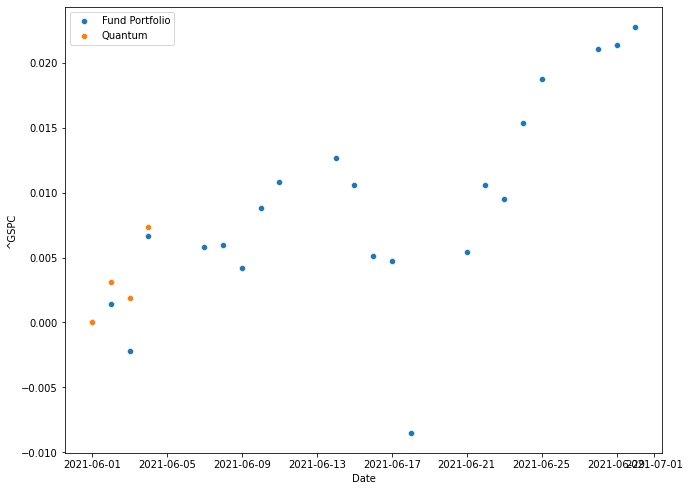


Run completed.

idx: 2021-06-07 00:00:00
new purchase budget: 1323721.8018226624, initial_budget: 1310332.3100309372
init_holdings before calculation: {'A': 46, 'AAL': 0, 'AAP': 39, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABMD': 0, 'ABT': 696, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 16, 'ADP': 0, 'ADSK': 0, 'AEE': 73, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 94, 'AKAM': 18, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 5, 'ALLE': 53, 'AMAT': 0, 'AMCR': 544, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 47, 'AMZN': 66, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 14, 'APA': 0, 'APD': 22, 'APH': 0, 'APTV': 0, 'ARE': 51, 'ATO': 0, 'ATVI': 0, 'AVB': 118, 'AVGO': 0, 'AVY': 26, 'AWK': 44, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 27, 'BALL': 0, 'BAX': 118, 'BBWI': 136, 'BBY': 184, 'BDX': 0, 'BEN': 69, 'BIIB': 0, 'BIO': 0, 'BK': 34, 'BKNG': 0, 'BKR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRO': 0, 'BSX': 0, 'BWA': 0, 'BXP': 0, 'C': 100, 'CAG': 0, 'CAH': 29, 'CARR': 257, 'CAT': 0, 'CB': 6, 'CBOE': 

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000043,-0.000119,0.000004,0.000039,0.000024,-0.000010,0.000056,0.000117,0.000023,0.000041,0.000083,0.000065,-0.000014,-0.000006,0.000122,0.000007,0.000015,-0.000007,-0.000005,-0.000013,0.000016,0.000013,0.000024,0.000044,0.000074,0.000012,-0.000006,0.000037,0.000060,0.000025,0.000035,0.000012,0.000037,-0.000003,-0.000018,0.000015,0.000056,0.000092,0.000003,0.000017,-1.509146e-04,-0.000009,0.000032,0.000013,-0.000019,-0.000027,0.000065,-0.000038,0.000073,0.000022,9.840514e-06,-0.000028,-0.000007,-0.000060,-0.000022,-0.000022,0.000027,0.000017,-0.000014,0.000020,-0.000014,-0.000050,0.000053,-7.248489e-09,0.000058,-0.000069,0.000006,0.000024,0.000046,0.000014,0.000066,-0.000042,-0.000037,-0.000022,-0.000008,-0.000007,0.000008,-5.028868e-06,-0.000009,-0.000006,-0.000047,-0.000014,-0.000083,0.000083,0.000079,0.000031,-0.000020,-0.000026,-2.660420e-05,0.000020,0.000007,0.000050,-0.000017,1.896004e-05,0.000014,-1.955258e-06,-0.000017,0.000040,0.000026,0.000011,0.000010,0.000009,-0.000015,0.000013,-0.000045,0.000017,-0.000059,-7.870142e-09,0.000009,0.000077,-0.000037,0.000073,0.000130,0.000030,0.000040,0.000010,0.000018,0.000049,-0.000014,0.000036,-0.000005,-0.000010,-0.000023,-0.000010,-0.000002,-0.000005,-9.448644e-07,-0.000010,-0.000039,0.000004,0.000050,0.000059,0.000090,0.000020,-0.000049,-3.011803e-05,-0.000008,0.000013,-0.000032,0.000037,0.000061,-0.000003,-0.000011,-0.000014,-0.000170,-0.000093,0.000044,0.000054,0.000014,0.000019,0.000011,0.000070,0.000015,0.000025,0.000005,-0.000025,-0.000005,0.000054,-0.000068,3.601197e-05,-0.000016,-0.000051,-0.000050,0.000002,-0.000066,0.000031,0.000008,-0.000081,0.000020,0.000073,-0.000007,0.000035,4.144034e-05,-0.000019,-0.000076,-0.000127,0.000040,-0.000019,0.000046,-0.000003,-0.000019,0.000081,0.000016,0.000027,-0.000013,-0.000011,-0.000003,0.000046,0.000038,8.473034e-07,-5.984132e-05,0.000001,0.000089,-0.000007,0.000026,-0.000041,0.000004,0.0000

covariance_matrix sum: 2.1196072556829693
corr matrix


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,-0.612494,0.041639,0.554761,0.489515,-0.212451,0.650367,0.420908,0.635384,0.797594,0.884572,0.762891,-0.244327,-0.132170,0.856260,0.235027,0.350133,-0.097659,-0.169743,-0.217128,0.296759,0.341310,0.476368,0.318516,0.561892,0.114776,-0.114798,0.980715,0.628832,0.407881,0.343527,0.321961,0.551010,-0.104664,-0.480324,0.304056,0.565250,0.676857,0.093531,0.177523,-0.517217,-0.171327,0.502852,0.117190,-0.531236,-0.785253,0.908779,-0.634109,0.603333,0.267476,0.281037,-0.523341,-0.278453,-0.485674,-0.464023,-0.290808,0.570320,0.123223,-0.106690,0.396928,-0.240426,-0.049882,0.547651,-0.000270,0.860061,-0.464726,0.152684,0.794078,0.685810,0.385292,0.572287,-0.335564,-0.434141,-0.549471,-0.160801,-0.062328,0.095812,-0.090293,-0.121375,-0.089612,-0.579247,-0.277646,-0.566846,0.801261,0.904439,0.460805,-0.259295,-0.241567,-0.545591,0.373148,0.093455,0.935019,-0.303433,0.372306,0.234774,-0.090327,-0.519349,0.947353,0.288053,0.176859,0.115481,0.299994,-0.472567,0.264773,-0.400811,0.376542,-0.541681,-0.000082,0.135800,0.941803,-0.588374,0.818707,0.732670,0.641844,0.583539,0.222293,0.437269,0.407740,-0.129304,0.830905,-0.116906,-0.225240,-0.277032,-0.166014,-0.031188,-0.057848,-0.018022,-0.138645,-0.461634,0.068308,0.508901,0.704468,0.785335,0.582403,-0.362041,-0.599091,-0.062860,0.330792,-0.238285,0.584748,0.418179,-0.170816,-0.367737,-0.248525,-0.458293,-0.691129,0.615074,0.670537,0.191249,0.446495,0.274076,0.806879,0.400689,0.653871,0.121957,-0.203937,-0.108923,0.388063,-0.495822,0.536088,-0.247661,-0.677702,-0.387784,0.023435,-0.784403,0.545197,0.205526,-0.290720,0.396539,0.788357,-0.157791,0.473891,0.438981,-0.366095,-0.351021,-0.585269,0.880497,-0.122291,0.474954,-0.063943,-0.694909,0.574166,0.222936,0.294484,-0.552309,-0.197345,-0.061287,0.659707,0.507777,0.031720,-0.723486,0.013376,0.875498,-0.109590,0.428498,-0.683895,0.051845,0.625600,0.170420,-0.295876,0.613674,-0.210421,0.902187,0.6430

correlation_matrix sum: 16945.839961297235


In [ ]:
#print('initial df')
#display(df.head())

if not init_holdings_path: 
    init_holdings_df, budget = generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget)
    init_holdings_df.to_pickle(save_path+'init_holdings.pkl')
else:
    init_holdings_df = pd.read_pickle(init_holdings_path)
    prices = df.loc[dates[0], :].values.tolist()
    print('init holdings df')
    display(init_holdings_df.head())
    print(f'prices: {prices}')
    pop = init_holdings_df['b'].values.tolist()
    print(f'pop: {pop}')
    budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])
    print(f'budget: {budget}')

init_holdings = {}
for idx, row in init_holdings_df.iterrows():
    init_holdings.update({row['a']: row['b']})
init_holdings = {s:0 for s in stocks}

#print(f'init_holdings: {init_holdings}')
#print(f'new budget: {budget}')
  
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists(save_path+label):
    os.makedirs(save_path+label)

my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )

my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)